# Supermasks in Superposition: Training and Task Inference

<img src="images/teaser_supsup.png">

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.autograd as autograd
import torch.nn.functional as F

import torchvision
import numpy as np
import math

from tqdm.notebook import tqdm

print("Packages loaded")
# note at edits

Packages loaded


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Training

We train our model using the procedure from "What's Hidden in a Randomly Weighted Neural Network" (Ramanujan et al. 2019). Below is a modification of the layers (using signed constant initialization) from this paper for our continual learning setup. As a deviation from this setup, we assume that an edge (u, v) is included in the subnetwork if its score is greater than 0, rather than use it's absolute magnitude to construct a threshold. 

In [3]:
# Subnetwork forward from hidden networks   
class GetSubnet(autograd.Function):
    @staticmethod
    def forward(ctx, scores, k):
        # Get the supermask by sorting the scores and using the top k%
        out = scores.clone()
        _, idx = scores.flatten().sort()
        j = int((1 - k) * scores.numel())

        # flat_out and out access the same memory.
        flat_out = out.flatten()
        flat_out[idx[:j]] = 0
        flat_out[idx[j:]] = 1

        return out

    @staticmethod
    def backward(ctx, g):
        # send the gradient g straight-through on the backward pass.
        return g, None

def mask_init(module):
    scores = torch.Tensor(module.weight.size())
    nn.init.kaiming_uniform_(scores, a=math.sqrt(5))
    return scores


def signed_constant(module):
    fan = nn.init._calculate_correct_fan(module.weight, 'fan_in')
    gain = nn.init.calculate_gain('relu')
    std = gain / math.sqrt(fan)
    module.weight.data = module.weight.data.sign() * std


class MultitaskMaskLinear(nn.Linear):
    def __init__(self, *args, num_tasks=1, sparsity=0.5, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_tasks = num_tasks
        self.sparsity = sparsity
        self.scores = nn.ParameterList(
            [
                nn.Parameter(mask_init(self))
                for _ in range(num_tasks)
            ]
        )
        
        # Keep weights untrained
        self.weight.requires_grad = False
        signed_constant(self)
    
    @torch.no_grad()
    def cache_masks(self):
        self.register_buffer(
            "stacked",
            torch.stack(
                [
                    GetSubnet.apply(self.scores[j], self.sparsity)
                    for j in range(self.num_tasks)
                ]
            ),
        )

    def forward(self, x):
        if self.task < 0:
            # Superimposed forward pass
            alpha_weights = self.alphas[: self.num_tasks_learned]
            idxs = (alpha_weights > 0).squeeze().view(self.num_tasks_learned)
            if len(idxs.shape) == 0:
                idxs = idxs.view(1)
            subnet = (
                alpha_weights[idxs]
                * self.stacked[: self.num_tasks_learned][idxs]
            ).sum(dim=0)
        else:
            # Subnet forward pass (given task info in self.task)
            subnet = GetSubnet.apply(self.scores[self.task], self.sparsity)
        w = self.weight * subnet
        x = F.linear(x, w, self.bias)
        return x


    def __repr__(self):
        return f"MultitaskMaskLinear({self.shape()})"

In [4]:
class BasisMultitaskMaskLinear(nn.Linear):
    def __init__(self, *args, num_tasks=1, num_seed_tasks_learned=1, start_at_optimal=True, sparsity=0.5, **kwargs):
        super().__init__(*args, **kwargs)
        assert num_tasks >= num_seed_tasks_learned, "Seed tasks cannot be more than total tasks!"
        self.num_tasks = num_tasks
        self.num_seed_tasks_learned = num_seed_tasks_learned
        self.sparsity = sparsity
        self.scores = nn.ParameterList(
            [
                nn.Parameter(mask_init(self))
                for _ in range(num_tasks)
            ]
        )
        self.task = -1
        
        # Keep weights untrained
        self.weight.requires_grad = False
        for s in self.scores:
            s.requires_grad = False
        self.scores.requires_grad = False
        if start_at_optimal:
            self.basis_alphas = nn.ParameterList(
                [
                    nn.Parameter(torch.eye(self.num_seed_tasks_learned)[i])
                    for i in range(self.num_seed_tasks_learned)
                ]
                +
                [
                    nn.Parameter(torch.ones(self.num_seed_tasks_learned)/self.num_seed_tasks_learned)
                    for _ in range(self.num_seed_tasks_learned, self.num_tasks)
                ]
            )
        else:
            self.basis_alphas = nn.ParameterList(
                [
                    nn.Parameter(torch.ones(self.num_seed_tasks_learned)/self.num_seed_tasks_learned)
                    for _ in range(self.num_tasks)
                ]
            )
        
        signed_constant(self)
    
    @torch.no_grad()
    def cache_masks(self):
        self.register_buffer(
            "stacked",
            torch.stack(
                [
                    GetSubnet.apply(self.scores[j], self.sparsity)
                    for j in range(self.num_tasks)
                ]
            ),
        )

    def forward(self, x):
        if self.task < 0:
            raise NotImplemented("Need task identity at inference time.")
        else:
            # Subnet forward pass (given task info in self.task)
            subnet = self.stacked[: self.num_seed_tasks_learned][0]
            task_alpha = self.basis_alphas[self.task]
            w = self.weight * subnet * task_alpha[0]
            for i in range(1, self.num_seed_tasks_learned):
                subnet = self.stacked[: self.num_seed_tasks_learned][i]
                w += self.weight * subnet * task_alpha[i]
        x = F.linear(x, w, self.bias)
        return x


    def __repr__(self):
        return f"BasisMultitaskMaskLinear({self.shape()})"

In [5]:
class BasisMultitaskMaskLinearFrozen(nn.Linear):
    def __init__(self, *args, num_tasks=1, num_seed_tasks_learned=1, start_at_optimal=True, sparsity=0.5, **kwargs):
        super().__init__(*args, **kwargs)
        assert num_tasks >= num_seed_tasks_learned, "Seed tasks cannot be more than total tasks!"
        self.num_tasks = num_tasks
        self.sparsity = sparsity
        self.num_seed_tasks_learned = num_seed_tasks_learned
        self.scores = nn.ParameterList(
            [
                nn.Parameter(mask_init(self))
                for _ in range(num_tasks)
            ]
        )
        self.task = -1
        
        # Keep weights untrained
        self.weight.requires_grad = False
        for s in self.scores:
            s.requires_grad = False
        self.scores.requires_grad = False
        if start_at_optimal:
            self.basis_alphas = nn.ParameterList(
                [
                    nn.Parameter(torch.eye(self.num_seed_tasks_learned)[i])
                    for i in range(self.num_seed_tasks_learned)
                ]
                +
                [
                    nn.Parameter(torch.ones(self.num_seed_tasks_learned)/self.num_seed_tasks_learned)
                    for _ in range(self.num_seed_tasks_learned, self.num_tasks)
                ]
            )
        else:
            self.basis_alphas = nn.ParameterList(
                [
                    nn.Parameter(torch.ones(self.num_seed_tasks_learned)/self.num_seed_tasks_learned)
                    for _ in range(self.num_tasks)
                ]
            )
        for a in self.basis_alphas:
            a.requires_grad = False
        self.basis_alphas.requires_grad = False
        
        signed_constant(self)
    
    @torch.no_grad()
    def cache_masks(self):
        self.register_buffer(
            "stacked",
            torch.stack(
                [
                    GetSubnet.apply(self.scores[j], self.sparsity)
                    for j in range(self.num_tasks)
                ]
            ),
        )

    def forward(self, x):
        if self.task < 0:
            raise NotImplemented("Need task identity at inference time.")
        else:
            # Subnet forward pass (given task info in self.task)
            subnet = self.stacked[: self.num_seed_tasks_learned][0]
            task_alpha = self.basis_alphas[self.task]
            w = self.weight * subnet * task_alpha[0]
            for i in range(1, self.num_seed_tasks_learned):
                subnet = self.stacked[: self.num_seed_tasks_learned][i]
                w += self.weight * subnet * task_alpha[i]
        x = F.linear(x, w, self.bias)
        return x


    def __repr__(self):
        return f"BasisMultitaskMaskLinearFrozen({self.shape()})"

In [6]:
ValidConvs = [
    MultitaskMaskLinear,
    BasisMultitaskMaskLinear,
    BasisMultitaskMaskLinearFrozen,
]

def isoftype(m, cls_lst):
    return any([isinstance(m, c) for c in cls_lst])

In [7]:
# Utility functions
def set_model_task(model, task, verbose=True):
    for n, m in model.named_modules():
        if isoftype(m, ValidConvs):
            if verbose:
                print(f"=> Set task of {n} to {task}")
            m.task = task

def cache_masks(model):
    for n, m in model.named_modules():
        if isoftype(m, ValidConvs):
            print(f"=> Caching mask state for {n}")
            m.cache_masks()

def set_num_tasks_learned(model, num_tasks_learned):
    for n, m in model.named_modules():
        if isoftype(m, ValidConvs):
            print(f"=> Setting learned tasks of {n} to {num_tasks_learned}")
            m.num_tasks_learned = num_tasks_learned

def set_alphas(model, alphas, verbose=True):
    for n, m in model.named_modules():
        if isoftype(m, ValidConvs):
            if verbose:
                print(f"=> Setting alphas for {n}")
            m.alphas = alphas

## Model

For simplicity we use a simple 3-layer fully connected neural network. Note that you can make any neural by replacing a standard layer with its corresponding mask layer.

In [8]:
# Multitask Model, a simple fully connected model in this case
class MultitaskFC(nn.Module):
    def __init__(self, hidden_size, num_tasks, sparsity):
        super().__init__()
        self.model = nn.Sequential(
            MultitaskMaskLinear(
                784,
                hidden_size,
                num_tasks=num_tasks,
                sparsity=sparsity,
                bias=False
            ),
            nn.ReLU(),
            MultitaskMaskLinear(
                hidden_size,
                hidden_size,
                num_tasks=num_tasks,
                sparsity=sparsity,
                bias=False
            ),
            nn.ReLU(),
            MultitaskMaskLinear(
                hidden_size,
                100,
                num_tasks=num_tasks,
                sparsity=sparsity,
                bias=False
            )
        )
    
    def forward(self, x):
        return self.model(x.flatten(1))

In [9]:
# Multitask Model, a simple fully connected model in this case
class BasisMultitaskFC(nn.Module):
    def __init__(self, hidden_size, num_tasks, num_seed_tasks_learned, sparsity, start_at_optimal=True):
        super().__init__()
        self.model = nn.Sequential(
            BasisMultitaskMaskLinear(
                784,
                hidden_size,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                sparsity=sparsity,
                bias=False
            ),
            nn.ReLU(),
            BasisMultitaskMaskLinear(
                hidden_size,
                hidden_size,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                sparsity=sparsity,
                bias=False
            ),
            nn.ReLU(),
            BasisMultitaskMaskLinear(
                hidden_size,
                100,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                sparsity=sparsity,
                bias=False
            )
        )
    
    def forward(self, x):
        return self.model(x.flatten(1))

In [10]:
class BasisHiddenOnlyMultitaskFC(nn.Module):
    def __init__(self, hidden_size, num_tasks, num_seed_tasks_learned, sparsity, start_at_optimal=True):
        super().__init__()
        self.model = nn.Sequential(
            BasisMultitaskMaskLinear(
                784,
                hidden_size,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                sparsity=sparsity,
                bias=False
            ),
            nn.ReLU(),
            BasisMultitaskMaskLinear(
                hidden_size,
                hidden_size,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                sparsity=sparsity,
                bias=False
            ),
            nn.ReLU(),
            MultitaskMaskLinear(
                hidden_size,
                100,
                num_tasks=num_tasks,
                sparsity=sparsity,
                bias=False
            )
        )
    
    def forward(self, x):
        return self.model(x.flatten(1))

In [11]:
class BasisHiddenOnlyFrozenMultitaskFC(nn.Module):
    def __init__(self, hidden_size, num_tasks, num_seed_tasks_learned, sparsity, start_at_optimal=True):
        super().__init__()
        self.model = nn.Sequential(
            BasisMultitaskMaskLinearFrozen(
                784,
                hidden_size,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                sparsity=sparsity,
                bias=False
            ),
            nn.ReLU(),
            BasisMultitaskMaskLinearFrozen(
                hidden_size,
                hidden_size,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                sparsity=sparsity,
                bias=False
            ),
            nn.ReLU(),
            MultitaskMaskLinear(
                hidden_size,
                100,
                num_tasks=num_tasks,
                sparsity=sparsity,
                bias=False
            )
        )
    
    def forward(self, x):
        return self.model(x.flatten(1))

## Dataset 

Our "base" dataset is MNIST. Each task is a random permutation of the pixels of MNIST. Namely, given a dataset $\{(x_i, y_i)\}_i$ for each task $t$, we take a random permutation $S^t\in S_{784}$ and construct a dataset $\{(S^t(x_i), y_i)\}_i$. 

Below we show this process and an example of a particular task. `MNISTPerm` uses an update task method to generate a particular sub-task. To assure these splits are reproducible, `MNISTPerm` takes a `seed` argument. In our paper we evaluate on seeds 0 through 4.

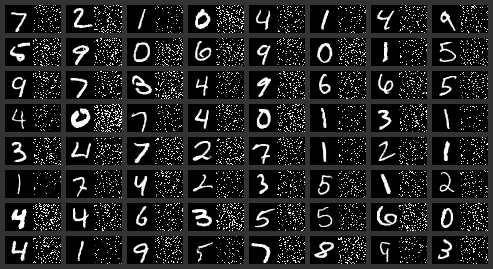

In [12]:
class MNISTPerm:
    class permute(object):
        def __call__(self, tensor):
            out = tensor.flatten()
            out = out[self.perm]
            return out.view(1, 28, 28)

        def __repr__(self):
            return self.__class__.__name__

    def __init__(self, seed=0):
        super(MNISTPerm, self).__init__()
        
        data_root = "mnist"
        self.permuter = self.permute()
        self.seed = seed
        train_dataset = torchvision.datasets.MNIST(
            data_root,
            train=True,
            download=True,
            transform=torchvision.transforms.Compose(
                [
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize((0.1307,), (0.3081,)),
                    self.permuter,
                ]
            ),
        )

        # Data loading code
        self.train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=128, shuffle=True
        )
        self.val_loader = torch.utils.data.DataLoader(
            torchvision.datasets.MNIST(
                data_root,
                train=False,
                transform=torchvision.transforms.Compose(
                    [
                        torchvision.transforms.ToTensor(),
                        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
                        self.permuter,
                    ]
                ),
            ),
            batch_size=128,
            shuffle=False,
        )

    def update_task(self, i):
        np.random.seed(i + self.seed)
        self.permuter.__setattr__("perm", np.random.permutation(784))
    
    def unpermute(self):
        self.permuter.__setattr__("perm", np.arange(784))

mnist = MNISTPerm()

# Showing some example images from MNISTPerm
mnist.unpermute()
batch, labels = next(iter(mnist.val_loader))

mnist.update_task(0)
task0, labels = next(iter(mnist.val_loader))

torchvision.transforms.ToPILImage()(
    torchvision.utils.make_grid(
        torch.cat([batch, task0], dim=-1)[:64],
        normalize=True,
        padding=5,
        pad_value=0.2
    )
)

### Simple train and evaluation loops for classification

In [13]:
# Finding supermasks per task

def train(model, trainloader, optimizer, epoch):
    model.train()

    criterion = nn.CrossEntropyLoss()
    num_correct = 0
    total_seen = 0
    for i, (batch, labels) in tqdm(
        enumerate(trainloader),
        ascii=True,
        total=len(trainloader)
    ):
        logits = model(batch)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 20 == 0:
            predictions = logits.argmax(dim=-1)
            num_correct += (predictions == labels).float().sum()
            total_seen += logits.size(0) 
            tqdm.write(
                (f"e{epoch} {i+1}/{len(trainloader)}"
                f" => Loss {loss.item():0.4f}, "
                f"Acc@1 {(num_correct / total_seen):0.4f}"),
                end="\r"
            )


@torch.no_grad()
def evaluate(model, val_loader, epoch):
    model.eval()
    num_correct = 0
    total_seen = 0
    for batch, labels in tqdm(
        val_loader,
        ascii=True,
        total=len(val_loader)
    ):
        logits = model(batch)
        predictions = logits.argmax(dim=-1)
        num_correct += (predictions == labels).float().sum()
        total_seen += logits.size(0) 
    

    tqdm.write(
        f"Val Perf after {epoch + 1} epochs "
        f"Acc@1 {(num_correct / total_seen):0.4f}", 
    )
    return num_correct / total_seen



For any scenario where task ID is given during train time, we simply train each supermask independently, one per task. We make use of our utility function `set_model_task` to do this. We use 5 tasks for demonstration purposes. Feel free to increase `num_tasks` in the following cell. In our paper we use as many as 2500 tasks with no drop in performance for either task inference or validation accuracy.

In [14]:
performance_map = {}

In [15]:
# Task ID given during train time
from IPython.display import clear_output

num_tasks = 50 # For demonstration purposes, we go up to 2500 in our paper
model = MultitaskFC(hidden_size=300, num_tasks=num_tasks, sparsity=0.25)

for task in range(num_tasks):
    print(f"Training for task {task}")
    set_model_task(model, task)
    mnist.update_task(task)

    optimizer = optim.RMSprop([p for p in model.parameters() if p.requires_grad], lr=1e-4)
    # Train for 1 epoch
    for e in range(1):
        train(model, mnist.train_loader, optimizer, e)
        
        print("Validation")
        print("============")
        acc1 = evaluate(model, mnist.val_loader, e)
        
    
    cache_masks(model)
    print()
    set_num_tasks_learned(model, task + 1)
    print()

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3245, Acc@1 0.8503


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9123
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 1
=> Set task of model.0 to 1
=> Set task of model.2 to 1
=> Set task of model.4 to 1


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3080, Acc@1 0.8350


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9123
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 2
=> Setting learned tasks of model.2 to 2
=> Setting learned tasks of model.4 to 2

Training for task 2
=> Set task of model.0 to 2
=> Set task of model.2 to 2
=> Set task of model.4 to 2


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3267, Acc@1 0.8408


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9141
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 3
=> Setting learned tasks of model.2 to 3
=> Setting learned tasks of model.4 to 3

Training for task 3
=> Set task of model.0 to 3
=> Set task of model.2 to 3
=> Set task of model.4 to 3


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3086, Acc@1 0.8369


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9144
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 4
=> Setting learned tasks of model.2 to 4
=> Setting learned tasks of model.4 to 4

Training for task 4
=> Set task of model.0 to 4
=> Set task of model.2 to 4
=> Set task of model.4 to 4


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2680, Acc@1 0.8392


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9112
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 5
=> Setting learned tasks of model.2 to 5
=> Setting learned tasks of model.4 to 5

Training for task 5
=> Set task of model.0 to 5
=> Set task of model.2 to 5
=> Set task of model.4 to 5


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3552, Acc@1 0.8206


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9153
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 6
=> Setting learned tasks of model.2 to 6
=> Setting learned tasks of model.4 to 6

Training for task 6
=> Set task of model.0 to 6
=> Set task of model.2 to 6
=> Set task of model.4 to 6


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3098, Acc@1 0.8379


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9124
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 7
=> Setting learned tasks of model.2 to 7
=> Setting learned tasks of model.4 to 7

Training for task 7
=> Set task of model.0 to 7
=> Set task of model.2 to 7
=> Set task of model.4 to 7


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2037, Acc@1 0.8356


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9112
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 8
=> Setting learned tasks of model.2 to 8
=> Setting learned tasks of model.4 to 8

Training for task 8
=> Set task of model.0 to 8
=> Set task of model.2 to 8
=> Set task of model.4 to 8


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3045, Acc@1 0.8467


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9154
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 9
=> Setting learned tasks of model.2 to 9
=> Setting learned tasks of model.4 to 9

Training for task 9
=> Set task of model.0 to 9
=> Set task of model.2 to 9
=> Set task of model.4 to 9


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3043, Acc@1 0.8395


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9143
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 10
=> Setting learned tasks of model.2 to 10
=> Setting learned tasks of model.4 to 10

Training for task 10
=> Set task of model.0 to 10
=> Set task of model.2 to 10
=> Set task of model.4 to 10


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2701, Acc@1 0.8340


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9144
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 11
=> Setting learned tasks of model.2 to 11
=> Setting learned tasks of model.4 to 11

Training for task 11
=> Set task of model.0 to 11
=> Set task of model.2 to 11
=> Set task of model.4 to 11


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3938, Acc@1 0.8333


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9104
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 12
=> Setting learned tasks of model.2 to 12
=> Setting learned tasks of model.4 to 12

Training for task 12
=> Set task of model.0 to 12
=> Set task of model.2 to 12
=> Set task of model.4 to 12


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4059, Acc@1 0.8382


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9161
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 13
=> Setting learned tasks of model.2 to 13
=> Setting learned tasks of model.4 to 13

Training for task 13
=> Set task of model.0 to 13
=> Set task of model.2 to 13
=> Set task of model.4 to 13


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3382, Acc@1 0.8431


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9120
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 14
=> Setting learned tasks of model.2 to 14
=> Setting learned tasks of model.4 to 14

Training for task 14
=> Set task of model.0 to 14
=> Set task of model.2 to 14
=> Set task of model.4 to 14


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3124, Acc@1 0.8337


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9123
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 15
=> Setting learned tasks of model.2 to 15
=> Setting learned tasks of model.4 to 15

Training for task 15
=> Set task of model.0 to 15
=> Set task of model.2 to 15
=> Set task of model.4 to 15


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4136, Acc@1 0.8327


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9117
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 16
=> Setting learned tasks of model.2 to 16
=> Setting learned tasks of model.4 to 16

Training for task 16
=> Set task of model.0 to 16
=> Set task of model.2 to 16
=> Set task of model.4 to 16


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2937, Acc@1 0.8356


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9107
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 17
=> Setting learned tasks of model.2 to 17
=> Setting learned tasks of model.4 to 17

Training for task 17
=> Set task of model.0 to 17
=> Set task of model.2 to 17
=> Set task of model.4 to 17


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3734, Acc@1 0.8320


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9143
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 18
=> Setting learned tasks of model.2 to 18
=> Setting learned tasks of model.4 to 18

Training for task 18
=> Set task of model.0 to 18
=> Set task of model.2 to 18
=> Set task of model.4 to 18


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3568, Acc@1 0.8369


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9106
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 19
=> Setting learned tasks of model.2 to 19
=> Setting learned tasks of model.4 to 19

Training for task 19
=> Set task of model.0 to 19
=> Set task of model.2 to 19
=> Set task of model.4 to 19


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3247, Acc@1 0.8424


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9048
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 20
=> Setting learned tasks of model.2 to 20
=> Setting learned tasks of model.4 to 20

Training for task 20
=> Set task of model.0 to 20
=> Set task of model.2 to 20
=> Set task of model.4 to 20


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4031, Acc@1 0.8411


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9109
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 21
=> Setting learned tasks of model.2 to 21
=> Setting learned tasks of model.4 to 21

Training for task 21
=> Set task of model.0 to 21
=> Set task of model.2 to 21
=> Set task of model.4 to 21


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2920, Acc@1 0.8473


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9132
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 22
=> Setting learned tasks of model.2 to 22
=> Setting learned tasks of model.4 to 22

Training for task 22
=> Set task of model.0 to 22
=> Set task of model.2 to 22
=> Set task of model.4 to 22


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2815, Acc@1 0.8447


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9125
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 23
=> Setting learned tasks of model.2 to 23
=> Setting learned tasks of model.4 to 23

Training for task 23
=> Set task of model.0 to 23
=> Set task of model.2 to 23
=> Set task of model.4 to 23


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2969, Acc@1 0.8464


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9118
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 24
=> Setting learned tasks of model.2 to 24
=> Setting learned tasks of model.4 to 24

Training for task 24
=> Set task of model.0 to 24
=> Set task of model.2 to 24
=> Set task of model.4 to 24


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4044, Acc@1 0.8385


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9130
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 25
=> Setting learned tasks of model.2 to 25
=> Setting learned tasks of model.4 to 25

Training for task 25
=> Set task of model.0 to 25
=> Set task of model.2 to 25
=> Set task of model.4 to 25


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4173, Acc@1 0.8369


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9115
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 26
=> Setting learned tasks of model.2 to 26
=> Setting learned tasks of model.4 to 26

Training for task 26
=> Set task of model.0 to 26
=> Set task of model.2 to 26
=> Set task of model.4 to 26


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3948, Acc@1 0.8366


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9131
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 27
=> Setting learned tasks of model.2 to 27
=> Setting learned tasks of model.4 to 27

Training for task 27
=> Set task of model.0 to 27
=> Set task of model.2 to 27
=> Set task of model.4 to 27


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2693, Acc@1 0.8434


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9118
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 28
=> Setting learned tasks of model.2 to 28
=> Setting learned tasks of model.4 to 28

Training for task 28
=> Set task of model.0 to 28
=> Set task of model.2 to 28
=> Set task of model.4 to 28


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2965, Acc@1 0.8340


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9121
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 29
=> Setting learned tasks of model.2 to 29
=> Setting learned tasks of model.4 to 29

Training for task 29
=> Set task of model.0 to 29
=> Set task of model.2 to 29
=> Set task of model.4 to 29


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3118, Acc@1 0.8382


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9135
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 30
=> Setting learned tasks of model.2 to 30
=> Setting learned tasks of model.4 to 30

Training for task 30
=> Set task of model.0 to 30
=> Set task of model.2 to 30
=> Set task of model.4 to 30


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2714, Acc@1 0.8330


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9107
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 31
=> Setting learned tasks of model.2 to 31
=> Setting learned tasks of model.4 to 31

Training for task 31
=> Set task of model.0 to 31
=> Set task of model.2 to 31
=> Set task of model.4 to 31


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2569, Acc@1 0.8542


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9081
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 32
=> Setting learned tasks of model.2 to 32
=> Setting learned tasks of model.4 to 32

Training for task 32
=> Set task of model.0 to 32
=> Set task of model.2 to 32
=> Set task of model.4 to 32


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4106, Acc@1 0.8366


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9130
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 33
=> Setting learned tasks of model.2 to 33
=> Setting learned tasks of model.4 to 33

Training for task 33
=> Set task of model.0 to 33
=> Set task of model.2 to 33
=> Set task of model.4 to 33


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3629, Acc@1 0.8424


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9117
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 34
=> Setting learned tasks of model.2 to 34
=> Setting learned tasks of model.4 to 34

Training for task 34
=> Set task of model.0 to 34
=> Set task of model.2 to 34
=> Set task of model.4 to 34


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3691, Acc@1 0.8421


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9147
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 35
=> Setting learned tasks of model.2 to 35
=> Setting learned tasks of model.4 to 35

Training for task 35
=> Set task of model.0 to 35
=> Set task of model.2 to 35
=> Set task of model.4 to 35


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3246, Acc@1 0.8376


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9117
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 36
=> Setting learned tasks of model.2 to 36
=> Setting learned tasks of model.4 to 36

Training for task 36
=> Set task of model.0 to 36
=> Set task of model.2 to 36
=> Set task of model.4 to 36


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2534, Acc@1 0.8320


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9124
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 37
=> Setting learned tasks of model.2 to 37
=> Setting learned tasks of model.4 to 37

Training for task 37
=> Set task of model.0 to 37
=> Set task of model.2 to 37
=> Set task of model.4 to 37


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2380, Acc@1 0.8483


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9122
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 38
=> Setting learned tasks of model.2 to 38
=> Setting learned tasks of model.4 to 38

Training for task 38
=> Set task of model.0 to 38
=> Set task of model.2 to 38
=> Set task of model.4 to 38


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3894, Acc@1 0.8438


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9070
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 39
=> Setting learned tasks of model.2 to 39
=> Setting learned tasks of model.4 to 39

Training for task 39
=> Set task of model.0 to 39
=> Set task of model.2 to 39
=> Set task of model.4 to 39


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2793, Acc@1 0.8379


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9134
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 40
=> Setting learned tasks of model.2 to 40
=> Setting learned tasks of model.4 to 40

Training for task 40
=> Set task of model.0 to 40
=> Set task of model.2 to 40
=> Set task of model.4 to 40


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3157, Acc@1 0.8307


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9108
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 41
=> Setting learned tasks of model.2 to 41
=> Setting learned tasks of model.4 to 41

Training for task 41
=> Set task of model.0 to 41
=> Set task of model.2 to 41
=> Set task of model.4 to 41


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4216, Acc@1 0.8464


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9113
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 42
=> Setting learned tasks of model.2 to 42
=> Setting learned tasks of model.4 to 42

Training for task 42
=> Set task of model.0 to 42
=> Set task of model.2 to 42
=> Set task of model.4 to 42


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2464, Acc@1 0.8395


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9129
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 43
=> Setting learned tasks of model.2 to 43
=> Setting learned tasks of model.4 to 43

Training for task 43
=> Set task of model.0 to 43
=> Set task of model.2 to 43
=> Set task of model.4 to 43


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2216, Acc@1 0.8431


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9119
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 44
=> Setting learned tasks of model.2 to 44
=> Setting learned tasks of model.4 to 44

Training for task 44
=> Set task of model.0 to 44
=> Set task of model.2 to 44
=> Set task of model.4 to 44


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2885, Acc@1 0.8418


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9113
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 45
=> Setting learned tasks of model.2 to 45
=> Setting learned tasks of model.4 to 45

Training for task 45
=> Set task of model.0 to 45
=> Set task of model.2 to 45
=> Set task of model.4 to 45


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3408, Acc@1 0.8389


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9126
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 46
=> Setting learned tasks of model.2 to 46
=> Setting learned tasks of model.4 to 46

Training for task 46
=> Set task of model.0 to 46
=> Set task of model.2 to 46
=> Set task of model.4 to 46


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3094, Acc@1 0.8447


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9136
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 47
=> Setting learned tasks of model.2 to 47
=> Setting learned tasks of model.4 to 47

Training for task 47
=> Set task of model.0 to 47
=> Set task of model.2 to 47
=> Set task of model.4 to 47


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3136, Acc@1 0.8457


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9144
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 48
=> Setting learned tasks of model.2 to 48
=> Setting learned tasks of model.4 to 48

Training for task 48
=> Set task of model.0 to 48
=> Set task of model.2 to 48
=> Set task of model.4 to 48


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3547, Acc@1 0.8418


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9133
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 49
=> Setting learned tasks of model.2 to 49
=> Setting learned tasks of model.4 to 49

Training for task 49
=> Set task of model.0 to 49
=> Set task of model.2 to 49
=> Set task of model.4 to 49


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3256, Acc@1 0.8327


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9127
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 50
=> Setting learned tasks of model.2 to 50
=> Setting learned tasks of model.4 to 50



In [16]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(num_tasks):
    set_model_task(model, task)
    mnist.update_task(task)
    acc1 = evaluate(model, mnist.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(num_tasks):
    print(f"Task {t}: {gg_performance[t]:.4f}")

Average top 1 performance: 0.9123
Per task performance
Task 0: 0.9123
Task 1: 0.9123
Task 2: 0.9141
Task 3: 0.9144
Task 4: 0.9112
Task 5: 0.9153
Task 6: 0.9124
Task 7: 0.9112
Task 8: 0.9154
Task 9: 0.9143
Task 10: 0.9144
Task 11: 0.9104
Task 12: 0.9161
Task 13: 0.9120
Task 14: 0.9123
Task 15: 0.9117
Task 16: 0.9107
Task 17: 0.9143
Task 18: 0.9106
Task 19: 0.9048
Task 20: 0.9109
Task 21: 0.9132
Task 22: 0.9125
Task 23: 0.9118
Task 24: 0.9130
Task 25: 0.9115
Task 26: 0.9131
Task 27: 0.9118
Task 28: 0.9121
Task 29: 0.9135
Task 30: 0.9107
Task 31: 0.9081
Task 32: 0.9130
Task 33: 0.9117
Task 34: 0.9147
Task 35: 0.9117
Task 36: 0.9124
Task 37: 0.9122
Task 38: 0.9070
Task 39: 0.9134
Task 40: 0.9108
Task 41: 0.9113
Task 42: 0.9129
Task 43: 0.9119
Task 44: 0.9113
Task 45: 0.9126
Task 46: 0.9136
Task 47: 0.9144
Task 48: 0.9133
Task 49: 0.9127


In [17]:
performance_map['supsup_mnist'] = gg_performance.copy()

### Multimask Same Task 

In [18]:
num_masks_to_create = 40

In [19]:
loaders = {}
for i in range(num_masks_to_create):
    loaders[i] = MNISTPerm()

In [20]:
weight_dict = {k: v for k,v in model.state_dict().items() if k.endswith('weight')}

In [21]:
# Task ID given during train time
from IPython.display import clear_output

model_map = {}
for i in range(num_masks_to_create):
    modeli = MultitaskFC(hidden_size=300, num_tasks=1, sparsity=0.25)
    sdi = modeli.state_dict()
    sdi.update(weight_dict)
    modeli.load_state_dict(sdi)
    model_map[i] = modeli

In [22]:
for idx, modeli in model_map.items():
    for task in range(1):
        print(f"Training for task {task}")
        set_model_task(modeli, task)
        mnisti = loaders[idx]
        mnisti.update_task(task)

        optimizer1 = optim.RMSprop([p for p in modeli.parameters() if p.requires_grad], lr=1e-4)
        # Train for 1 epoch
        for e in range(1):
            train(modeli, mnisti.train_loader, optimizer1, e)
            
            print("Validation")
            print("============")
            acc1 = evaluate(modeli, mnisti.val_loader, e)


        cache_masks(modeli)
        print()
        set_num_tasks_learned(modeli, task + 1)
        print()

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3358, Acc@1 0.8366


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9164
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4087, Acc@1 0.8359


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9085
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2240, Acc@1 0.8493


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9067
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2797, Acc@1 0.8431


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9161
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2619, Acc@1 0.8402


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9101
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2333, Acc@1 0.8509


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9151
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3669, Acc@1 0.8314


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9112
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4344, Acc@1 0.8395


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9132
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3648, Acc@1 0.8405


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9135
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3109, Acc@1 0.8473


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9142
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2800, Acc@1 0.8363


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9140
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3516, Acc@1 0.8385


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9133
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2635, Acc@1 0.8356


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9124
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3482, Acc@1 0.8454


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9153
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.1974, Acc@1 0.8356


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9114
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3033, Acc@1 0.8369


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9119
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2982, Acc@1 0.8415


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9145
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3697, Acc@1 0.8438


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9121
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3314, Acc@1 0.8441


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9151
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2264, Acc@1 0.8395


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9136
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2762, Acc@1 0.8294


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9102
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3649, Acc@1 0.8304


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9141
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3203, Acc@1 0.8330


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9140
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3110, Acc@1 0.8424


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9077
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3506, Acc@1 0.8307


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9101
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4260, Acc@1 0.8408


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9109
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3874, Acc@1 0.8389


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9114
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2733, Acc@1 0.8467


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9116
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3966, Acc@1 0.8434


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9098
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2999, Acc@1 0.8402


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9120
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4134, Acc@1 0.8343


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9107
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4034, Acc@1 0.8402


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9151
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3331, Acc@1 0.8330


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9131
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4425, Acc@1 0.8258


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9042
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3012, Acc@1 0.8428


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9107
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3654, Acc@1 0.8369


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9114
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4089, Acc@1 0.8288


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9138
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3379, Acc@1 0.8545


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9143
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2193, Acc@1 0.8411


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9100
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3955, Acc@1 0.8382


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9147
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1



In [23]:
def overlap(mask1, mask2):
    assert mask1.shape == mask2.shape
    count_same = (mask1 + mask2 - 1).abs().sum()
    return count_same / (1.0*(mask1.shape[0] * mask1.shape[1]))

In [24]:
from itertools import product

In [25]:
task = 0
for layer, modelidx in product([0,2,4], product([i for i in range(15)], [i for i in range(15)])):
    modeli, modelj = modelidx
    if modeli == modelj:
        continue
    print('Layer: {}, Models: ({}, {}), Overlap: {}'.format(layer, modeli, modelj,
        overlap(model_map[modeli].state_dict()['model.{}.stacked'.format(layer)][task],
                model_map[modelj].state_dict()['model.{}.stacked'.format(layer)][task])))

Layer: 0, Models: (0, 1), Overlap: 0.6442686915397644
Layer: 0, Models: (0, 2), Overlap: 0.6420068144798279
Layer: 0, Models: (0, 3), Overlap: 0.6416071653366089
Layer: 0, Models: (0, 4), Overlap: 0.6425085067749023
Layer: 0, Models: (0, 5), Overlap: 0.6434183716773987
Layer: 0, Models: (0, 6), Overlap: 0.6419727802276611
Layer: 0, Models: (0, 7), Overlap: 0.6440390944480896
Layer: 0, Models: (0, 8), Overlap: 0.6413435339927673
Layer: 0, Models: (0, 9), Overlap: 0.6436904668807983
Layer: 0, Models: (0, 10), Overlap: 0.6424234509468079
Layer: 0, Models: (0, 11), Overlap: 0.642380952835083
Layer: 0, Models: (0, 12), Overlap: 0.6446598768234253
Layer: 0, Models: (0, 13), Overlap: 0.6445407867431641
Layer: 0, Models: (0, 14), Overlap: 0.6431037187576294
Layer: 0, Models: (1, 0), Overlap: 0.6442686915397644
Layer: 0, Models: (1, 2), Overlap: 0.6431037187576294
Layer: 0, Models: (1, 3), Overlap: 0.6416666507720947
Layer: 0, Models: (1, 4), Overlap: 0.6440390944480896
Layer: 0, Models: (1, 5)

Layer: 0, Models: (11, 0), Overlap: 0.642380952835083
Layer: 0, Models: (11, 1), Overlap: 0.6429081559181213
Layer: 0, Models: (11, 2), Overlap: 0.6415390968322754
Layer: 0, Models: (11, 3), Overlap: 0.6413435339927673
Layer: 0, Models: (11, 4), Overlap: 0.6424149870872498
Layer: 0, Models: (11, 5), Overlap: 0.6434949040412903
Layer: 0, Models: (11, 6), Overlap: 0.6419897675514221
Layer: 0, Models: (11, 7), Overlap: 0.6441581845283508
Layer: 0, Models: (11, 8), Overlap: 0.6419302821159363
Layer: 0, Models: (11, 9), Overlap: 0.6440731287002563
Layer: 0, Models: (11, 10), Overlap: 0.6440646052360535
Layer: 0, Models: (11, 12), Overlap: 0.6443962454795837
Layer: 0, Models: (11, 13), Overlap: 0.6433163285255432
Layer: 0, Models: (11, 14), Overlap: 0.643146276473999
Layer: 0, Models: (12, 0), Overlap: 0.6446598768234253
Layer: 0, Models: (12, 1), Overlap: 0.6443537473678589
Layer: 0, Models: (12, 2), Overlap: 0.642397940158844
Layer: 0, Models: (12, 3), Overlap: 0.6426530480384827
Layer: 0,

Layer: 4, Models: (4, 5), Overlap: 0.6474666595458984
Layer: 4, Models: (4, 6), Overlap: 0.638866662979126
Layer: 4, Models: (4, 7), Overlap: 0.643666684627533
Layer: 4, Models: (4, 8), Overlap: 0.6432666778564453
Layer: 4, Models: (4, 9), Overlap: 0.6450666785240173
Layer: 4, Models: (4, 10), Overlap: 0.6452000141143799
Layer: 4, Models: (4, 11), Overlap: 0.6432666778564453
Layer: 4, Models: (4, 12), Overlap: 0.6408666372299194
Layer: 4, Models: (4, 13), Overlap: 0.6450666785240173
Layer: 4, Models: (4, 14), Overlap: 0.6388000249862671
Layer: 4, Models: (5, 0), Overlap: 0.645799994468689
Layer: 4, Models: (5, 1), Overlap: 0.6447333097457886
Layer: 4, Models: (5, 2), Overlap: 0.6394666433334351
Layer: 4, Models: (5, 3), Overlap: 0.6425999999046326
Layer: 4, Models: (5, 4), Overlap: 0.6474666595458984
Layer: 4, Models: (5, 6), Overlap: 0.644599974155426
Layer: 4, Models: (5, 7), Overlap: 0.6451333165168762
Layer: 4, Models: (5, 8), Overlap: 0.6448666453361511
Layer: 4, Models: (5, 9), O

# Basis Masks 

### Model Initialization (Only New Tasks)

In [26]:
num_tasks = 50 # For demonstration purposes, we go up to 2500 in our paper
num_seed_tasks_learned = 40
basis_model = BasisMultitaskFC(hidden_size=300, num_tasks=num_tasks, num_seed_tasks_learned=num_seed_tasks_learned, start_at_optimal=True, sparsity=0.25)

In [27]:
seed_dict = model.state_dict()
basis_dict = basis_model.state_dict()
load_dict = {k: seed_dict[k] for k in basis_model.state_dict().keys() if k in seed_dict.keys()}
basis_dict.update(load_dict)
basis_model.load_state_dict(basis_dict, False)
cache_masks(basis_model)

=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4


In [28]:
for task in range(num_seed_tasks_learned, num_tasks):
    print(f"Training for task {task}")
    set_model_task(basis_model, task)
    mnist.update_task(task)

    optimizer = optim.RMSprop([p for p in basis_model.parameters() if p.requires_grad], lr=1e-3)
    # Train for 1 epoch
    for e in range(2):
        train(basis_model, mnist.train_loader, optimizer, e)
        
        print("Validation")
        print("============")
        acc1 = evaluate(basis_model, mnist.val_loader, e)
        
    
    cache_masks(basis_model)
    print()
    set_num_tasks_learned(basis_model, task + 1)
    print()

Training for task 40
=> Set task of model.0 to 40
=> Set task of model.2 to 40
=> Set task of model.4 to 40


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.5575, Acc@1 0.3060


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4635


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.2256, Acc@1 0.5085


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5387
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 41
=> Setting learned tasks of model.2 to 41
=> Setting learned tasks of model.4 to 41

Training for task 41
=> Set task of model.0 to 41
=> Set task of model.2 to 41
=> Set task of model.4 to 41


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.6740, Acc@1 0.2939


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4347


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3222, Acc@1 0.5059


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5479
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 42
=> Setting learned tasks of model.2 to 42
=> Setting learned tasks of model.4 to 42

Training for task 42
=> Set task of model.0 to 42
=> Set task of model.2 to 42
=> Set task of model.4 to 42


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.4927, Acc@1 0.3356


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.5106


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.4507, Acc@1 0.5417


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5857
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 43
=> Setting learned tasks of model.2 to 43
=> Setting learned tasks of model.4 to 43

Training for task 43
=> Set task of model.0 to 43
=> Set task of model.2 to 43
=> Set task of model.4 to 43


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.4743, Acc@1 0.3158


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4667


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3278, Acc@1 0.4801


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5370
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 44
=> Setting learned tasks of model.2 to 44
=> Setting learned tasks of model.4 to 44

Training for task 44
=> Set task of model.0 to 44
=> Set task of model.2 to 44
=> Set task of model.4 to 44


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.6210, Acc@1 0.3037


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4761


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3181, Acc@1 0.5358


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5858
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 45
=> Setting learned tasks of model.2 to 45
=> Setting learned tasks of model.4 to 45

Training for task 45
=> Set task of model.0 to 45
=> Set task of model.2 to 45
=> Set task of model.4 to 45


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.6129, Acc@1 0.3278


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4716


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.2530, Acc@1 0.5091


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5631
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 46
=> Setting learned tasks of model.2 to 46
=> Setting learned tasks of model.4 to 46

Training for task 46
=> Set task of model.0 to 46
=> Set task of model.2 to 46
=> Set task of model.4 to 46


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.7034, Acc@1 0.2809


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4134


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3144, Acc@1 0.4990


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5414
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 47
=> Setting learned tasks of model.2 to 47
=> Setting learned tasks of model.4 to 47

Training for task 47
=> Set task of model.0 to 47
=> Set task of model.2 to 47
=> Set task of model.4 to 47


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.5168, Acc@1 0.3210


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4992


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3096, Acc@1 0.5485


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5841
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 48
=> Setting learned tasks of model.2 to 48
=> Setting learned tasks of model.4 to 48

Training for task 48
=> Set task of model.0 to 48
=> Set task of model.2 to 48
=> Set task of model.4 to 48


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.7470, Acc@1 0.3314


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4122


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3437, Acc@1 0.4801


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5157
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 49
=> Setting learned tasks of model.2 to 49
=> Setting learned tasks of model.4 to 49

Training for task 49
=> Set task of model.0 to 49
=> Set task of model.2 to 49
=> Set task of model.4 to 49


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.4629, Acc@1 0.3324


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.5028


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3120, Acc@1 0.5462


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5697
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 50
=> Setting learned tasks of model.2 to 50
=> Setting learned tasks of model.4 to 50



In [29]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(num_tasks):
    set_model_task(basis_model, task)
    mnist.update_task(task)
    acc1 = evaluate(basis_model, mnist.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(num_tasks):
    print(f"Task {t}: {gg_performance[t]:.4f}")

Average top 1 performance: 0.8412
Per task performance
Task 0: 0.9123
Task 1: 0.9123
Task 2: 0.9141
Task 3: 0.9144
Task 4: 0.9112
Task 5: 0.9153
Task 6: 0.9124
Task 7: 0.9112
Task 8: 0.9154
Task 9: 0.9143
Task 10: 0.9144
Task 11: 0.9104
Task 12: 0.9161
Task 13: 0.9120
Task 14: 0.9123
Task 15: 0.9117
Task 16: 0.9107
Task 17: 0.9143
Task 18: 0.9106
Task 19: 0.9048
Task 20: 0.9109
Task 21: 0.9132
Task 22: 0.9125
Task 23: 0.9118
Task 24: 0.9130
Task 25: 0.9115
Task 26: 0.9131
Task 27: 0.9118
Task 28: 0.9121
Task 29: 0.9135
Task 30: 0.9107
Task 31: 0.9081
Task 32: 0.9130
Task 33: 0.9117
Task 34: 0.9147
Task 35: 0.9117
Task 36: 0.9124
Task 37: 0.9122
Task 38: 0.9070
Task 39: 0.9134
Task 40: 0.5387
Task 41: 0.5479
Task 42: 0.5857
Task 43: 0.5370
Task 44: 0.5858
Task 45: 0.5631
Task 46: 0.5414
Task 47: 0.5841
Task 48: 0.5157
Task 49: 0.5697


In [30]:
performance_map['basis_mnist'] = gg_performance.copy()

### Model Initialization (Cross task analysis) -- Using 1 mask from task 0

In [31]:
num_tasks = 10 # For demonstration purposes, we go up to 2500 in our paper
num_seed_tasks_learned = 1
basis_model_f = BasisMultitaskFC(hidden_size=300,
                            num_tasks=num_tasks, num_seed_tasks_learned=num_seed_tasks_learned, start_at_optimal=True, sparsity=0.25)

In [32]:
custom_state_dict = basis_model_f.state_dict().copy()
custom_state_dict.update({k:v for k,v in model.state_dict().items() if k in custom_state_dict.keys()})

In [33]:
for k in custom_state_dict.keys():
    if k.startswith('model.0.scores.'):
        custom_state_dict[k] = model.state_dict()['model.0.scores.0']
    elif k.startswith('model.2.scores.'):
        custom_state_dict[k] = model.state_dict()['model.2.scores.0']
    elif k.startswith('model.4.scores.'):
        custom_state_dict[k] = model.state_dict()['model.4.scores.0']
    elif k.startswith('model.0.basis_alphas.'):
        custom_state_dict[k] = custom_state_dict['model.0.basis_alphas.0'] 
    elif k.startswith('model.2.basis_alphas.'):
        custom_state_dict[k] = custom_state_dict['model.2.basis_alphas.0']
    elif k.startswith('model.4.basis_alphas.'):
        custom_state_dict[k] = custom_state_dict['model.4.basis_alphas.0']

In [34]:
basis_model_f.load_state_dict(custom_state_dict, False)
cache_masks(basis_model_f)

=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4


In [35]:
# for task in range(0, num_tasks):
#     print(f"Training for task {task}")
#     set_model_task(basis_model_hidf, task)
#     mnist.update_task(task)

#     optimizer = optim.RMSprop([p for p in basis_model_hidf.parameters() if p.requires_grad], lr=1e-3)
#     # Train for 1 epoch
#     for e in range(1):
#         train(basis_model_hidf, mnist.train_loader, optimizer, e)
        
#         print("Validation")
#         print("============")
#         acc1 = evaluate(basis_model_hidf, mnist.val_loader, e)
        
    
#     cache_masks(basis_model_hidf)
#     print()
#     set_num_tasks_learned(basis_model_hidf, task + 1)
#     print()

In [36]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(num_tasks):
    set_model_task(basis_model_f, task)
    mnist.update_task(task)
    acc1 = evaluate(basis_model_f, mnist.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(num_tasks):
    print(f"Task {t}: {gg_performance[t]:.4f}")

Average top 1 performance: 0.2064
Per task performance
Task 0: 0.9123
Task 1: 0.1757
Task 2: 0.1208
Task 3: 0.0909
Task 4: 0.1220
Task 5: 0.1697
Task 6: 0.0895
Task 7: 0.1300
Task 8: 0.1562
Task 9: 0.0971


In [37]:
performance_map['basis_mnist_frozen'] = gg_performance.copy()

### Model Initialization (Only New Tasks) , 15 masks all from task 0

In [38]:
num_tasks = 50 # For demonstration purposes, we go up to 2500 in our paper
num_seed_tasks_learned = 40
basis_model_zeros = BasisMultitaskFC(hidden_size=300, num_tasks=num_tasks, num_seed_tasks_learned=num_seed_tasks_learned, start_at_optimal=False, sparsity=0.25)

In [39]:
seed_dict = basis_model_zeros.state_dict()

In [40]:
update_dict = seed_dict.copy()

In [41]:
assert all([(model_map[0].state_dict()['model.0.weight'] == model_map[i].state_dict()['model.0.weight']).all() for i in range(1,15)])
update_dict['model.0.weight'] = model_map[0].state_dict()['model.0.weight']
for task in range(15):
    for layer in [0,2,4]:
        update_dict['model.{}.scores.{}'.format(layer, task)] = model_map[task].state_dict()['model.{}.scores.0'.format(layer)]

In [42]:
seed_dict.update(update_dict)
basis_model_zeros.load_state_dict(seed_dict, False)
cache_masks(basis_model_zeros)

=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4


In [43]:
num_seed_tasks_learned, num_tasks

(40, 50)

In [44]:
for task in range(num_seed_tasks_learned, num_tasks):
    print(f"Training for task {task}")
    set_model_task(basis_model_zeros, task)
    mnist.update_task(task)

    optimizer = optim.RMSprop([p for p in basis_model_zeros.parameters() if p.requires_grad], lr=1e-3)
    # Train for 1 epoch
    for e in range(2):
        train(basis_model_zeros, mnist.train_loader, optimizer, e)
        
        print("Validation")
        print("============")
        acc1 = evaluate(basis_model_zeros, mnist.val_loader, e)
        
    
    cache_masks(basis_model_zeros)
    print()
    set_num_tasks_learned(basis_model_zeros, task + 1)
    print()

Training for task 40
=> Set task of model.0 to 40
=> Set task of model.2 to 40
=> Set task of model.4 to 40


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.3973, Acc@1 0.2077


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3332


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.2227, Acc@1 0.3590


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4120
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 41
=> Setting learned tasks of model.2 to 41
=> Setting learned tasks of model.4 to 41

Training for task 41
=> Set task of model.0 to 41
=> Set task of model.2 to 41
=> Set task of model.4 to 41


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.6052, Acc@1 0.2673


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3579


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.0144, Acc@1 0.3936


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4369
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 42
=> Setting learned tasks of model.2 to 42
=> Setting learned tasks of model.4 to 42

Training for task 42
=> Set task of model.0 to 42
=> Set task of model.2 to 42
=> Set task of model.4 to 42


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.7551, Acc@1 0.2236


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3417


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.0114, Acc@1 0.3708


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4121
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 43
=> Setting learned tasks of model.2 to 43
=> Setting learned tasks of model.4 to 43

Training for task 43
=> Set task of model.0 to 43
=> Set task of model.2 to 43
=> Set task of model.4 to 43


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.2342, Acc@1 0.2653


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3801


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.9547, Acc@1 0.4450


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4793
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 44
=> Setting learned tasks of model.2 to 44
=> Setting learned tasks of model.4 to 44

Training for task 44
=> Set task of model.0 to 44
=> Set task of model.2 to 44
=> Set task of model.4 to 44


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.3228, Acc@1 0.2204


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3525


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.8646, Acc@1 0.4209


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4652
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 45
=> Setting learned tasks of model.2 to 45
=> Setting learned tasks of model.4 to 45

Training for task 45
=> Set task of model.0 to 45
=> Set task of model.2 to 45
=> Set task of model.4 to 45


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.4968, Acc@1 0.2334


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3668


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.7764, Acc@1 0.4049


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4435
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 46
=> Setting learned tasks of model.2 to 46
=> Setting learned tasks of model.4 to 46

Training for task 46
=> Set task of model.0 to 46
=> Set task of model.2 to 46
=> Set task of model.4 to 46


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.2520, Acc@1 0.2520


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3640


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.7504, Acc@1 0.4115


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4450
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 47
=> Setting learned tasks of model.2 to 47
=> Setting learned tasks of model.4 to 47

Training for task 47
=> Set task of model.0 to 47
=> Set task of model.2 to 47
=> Set task of model.4 to 47


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.2286, Acc@1 0.2666


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3663


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.7297, Acc@1 0.4199


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4630
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 48
=> Setting learned tasks of model.2 to 48
=> Setting learned tasks of model.4 to 48

Training for task 48
=> Set task of model.0 to 48
=> Set task of model.2 to 48
=> Set task of model.4 to 48


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.2583, Acc@1 0.2334


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3527


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.7529, Acc@1 0.4105


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4845
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 49
=> Setting learned tasks of model.2 to 49
=> Setting learned tasks of model.4 to 49

Training for task 49
=> Set task of model.0 to 49
=> Set task of model.2 to 49
=> Set task of model.4 to 49


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.1193, Acc@1 0.2184


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3565


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.8414, Acc@1 0.3991


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4672
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 50
=> Setting learned tasks of model.2 to 50
=> Setting learned tasks of model.4 to 50



In [45]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(num_tasks):
    set_model_task(basis_model_zeros, task)
    mnist.update_task(task)
    acc1 = evaluate(basis_model_zeros, mnist.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(num_tasks):
    print(f"Task {t}: {gg_performance[t]:.4f}")

Average top 1 performance: 0.0916
Per task performance
Task 0: 0.0000
Task 1: 0.0028
Task 2: 0.0001
Task 3: 0.0024
Task 4: 0.0080
Task 5: 0.0002
Task 6: 0.0000
Task 7: 0.0000
Task 8: 0.0007
Task 9: 0.0049
Task 10: 0.0025
Task 11: 0.0002
Task 12: 0.0004
Task 13: 0.0004
Task 14: 0.0006
Task 15: 0.0001
Task 16: 0.0047
Task 17: 0.0004
Task 18: 0.0003
Task 19: 0.0005
Task 20: 0.0004
Task 21: 0.0018
Task 22: 0.0031
Task 23: 0.0019
Task 24: 0.0002
Task 25: 0.0006
Task 26: 0.0015
Task 27: 0.0102
Task 28: 0.0017
Task 29: 0.0105
Task 30: 0.0001
Task 31: 0.0018
Task 32: 0.0003
Task 33: 0.0020
Task 34: 0.0012
Task 35: 0.0000
Task 36: 0.0027
Task 37: 0.0003
Task 38: 0.0010
Task 39: 0.0000
Task 40: 0.4120
Task 41: 0.4369
Task 42: 0.4121
Task 43: 0.4793
Task 44: 0.4652
Task 45: 0.4435
Task 46: 0.4450
Task 47: 0.4630
Task 48: 0.4845
Task 49: 0.4672


In [46]:
performance_map['basis_mnist_task_zero_only'] = gg_performance.copy()

## Except Final Layer

### Model Initialization (Only New Tasks)

In [47]:
num_tasks = 50 # For demonstration purposes, we go up to 2500 in our paper
num_seed_tasks_learned = 40
basis_model_hid = BasisHiddenOnlyMultitaskFC(hidden_size=300, num_tasks=num_tasks, num_seed_tasks_learned=num_seed_tasks_learned, start_at_optimal=True, sparsity=0.25)

In [48]:
seed_dict_hid = model.state_dict()
basis_dict_hid = basis_model_hid.state_dict()
load_dict_hid = {k: seed_dict_hid[k] for k in basis_model_hid.state_dict().keys() if k in seed_dict_hid.keys()}
basis_dict_hid.update(load_dict_hid)
basis_model_hid.load_state_dict(basis_dict_hid, False)
cache_masks(basis_model_hid)

=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4


In [49]:
for task in range(num_seed_tasks_learned, num_tasks):
    print(f"Training for task {task}")
    set_model_task(basis_model_hid, task)
    mnist.update_task(task)

    optimizer = optim.RMSprop([p for p in basis_model_hid.parameters() if p.requires_grad], lr=1e-4)
    # Train for 1 epoch
    for e in range(3):
        train(basis_model_hid, mnist.train_loader, optimizer, e)
        
        print("Validation")
        print("============")
        acc1 = evaluate(basis_model_hid, mnist.val_loader, e)
        
    
    cache_masks(basis_model_hid)
    print()
    set_num_tasks_learned(basis_model_hid, task + 1)
    print()

Training for task 40
=> Set task of model.0 to 40
=> Set task of model.2 to 40
=> Set task of model.4 to 40


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.8988, Acc@1 0.2686


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.5308


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.5069, Acc@1 0.5605


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6161


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.1827, Acc@1 0.6331


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 3 epochs Acc@1 0.6069
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 41
=> Setting learned tasks of model.2 to 41
=> Setting learned tasks of model.4 to 41

Training for task 41
=> Set task of model.0 to 41
=> Set task of model.2 to 41
=> Set task of model.4 to 41


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.8749, Acc@1 0.3050


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.5393


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3223, Acc@1 0.5762


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6274


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.2996, Acc@1 0.6439


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 3 epochs Acc@1 0.6569
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 42
=> Setting learned tasks of model.2 to 42
=> Setting learned tasks of model.4 to 42

Training for task 42
=> Set task of model.0 to 42
=> Set task of model.2 to 42
=> Set task of model.4 to 42


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.8787, Acc@1 0.3027


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.5595


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3625, Acc@1 0.6042


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6565


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.2514, Acc@1 0.6452


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 3 epochs Acc@1 0.6506
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 43
=> Setting learned tasks of model.2 to 43
=> Setting learned tasks of model.4 to 43

Training for task 43
=> Set task of model.0 to 43
=> Set task of model.2 to 43
=> Set task of model.4 to 43


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.8666, Acc@1 0.2995


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.5400


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.2625, Acc@1 0.5977


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6304


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3284, Acc@1 0.6377


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 3 epochs Acc@1 0.6308
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 44
=> Setting learned tasks of model.2 to 44
=> Setting learned tasks of model.4 to 44

Training for task 44
=> Set task of model.0 to 44
=> Set task of model.2 to 44
=> Set task of model.4 to 44


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.9764, Acc@1 0.3102


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.5412


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.4986, Acc@1 0.6042


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6605


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.2084, Acc@1 0.6475


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 3 epochs Acc@1 0.6510
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 45
=> Setting learned tasks of model.2 to 45
=> Setting learned tasks of model.4 to 45

Training for task 45
=> Set task of model.0 to 45
=> Set task of model.2 to 45
=> Set task of model.4 to 45


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.9138, Acc@1 0.2806


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.5026


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3431, Acc@1 0.5853


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6385


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.2624, Acc@1 0.6270


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 3 epochs Acc@1 0.6182
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 46
=> Setting learned tasks of model.2 to 46
=> Setting learned tasks of model.4 to 46

Training for task 46
=> Set task of model.0 to 46
=> Set task of model.2 to 46
=> Set task of model.4 to 46


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.9056, Acc@1 0.3298


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.5456


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.2275, Acc@1 0.6090


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6572


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.2908, Acc@1 0.6374


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 3 epochs Acc@1 0.6337
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 47
=> Setting learned tasks of model.2 to 47
=> Setting learned tasks of model.4 to 47

Training for task 47
=> Set task of model.0 to 47
=> Set task of model.2 to 47
=> Set task of model.4 to 47


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.7287, Acc@1 0.3451


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.5951


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.2471, Acc@1 0.6266


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6777


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.9639, Acc@1 0.6758


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 3 epochs Acc@1 0.7071
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 48
=> Setting learned tasks of model.2 to 48
=> Setting learned tasks of model.4 to 48

Training for task 48
=> Set task of model.0 to 48
=> Set task of model.2 to 48
=> Set task of model.4 to 48


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.8676, Acc@1 0.3193


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.5362


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3289, Acc@1 0.6051


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6657


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3327, Acc@1 0.6523


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 3 epochs Acc@1 0.6565
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 49
=> Setting learned tasks of model.2 to 49
=> Setting learned tasks of model.4 to 49

Training for task 49
=> Set task of model.0 to 49
=> Set task of model.2 to 49
=> Set task of model.4 to 49


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.8303, Acc@1 0.3350


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.5353


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3953, Acc@1 0.6048


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6364


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.4216, Acc@1 0.6090


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 3 epochs Acc@1 0.6100
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 50
=> Setting learned tasks of model.2 to 50
=> Setting learned tasks of model.4 to 50



In [50]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(num_tasks):
    set_model_task(basis_model_hid, task)
    mnist.update_task(task)
    acc1 = evaluate(basis_model_hid, mnist.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(num_tasks):
    print(f"Task {t}: {gg_performance[t]:.4f}")

Average top 1 performance: 0.8582
Per task performance
Task 0: 0.9123
Task 1: 0.9123
Task 2: 0.9141
Task 3: 0.9144
Task 4: 0.9112
Task 5: 0.9153
Task 6: 0.9124
Task 7: 0.9112
Task 8: 0.9154
Task 9: 0.9143
Task 10: 0.9144
Task 11: 0.9104
Task 12: 0.9161
Task 13: 0.9120
Task 14: 0.9123
Task 15: 0.9117
Task 16: 0.9107
Task 17: 0.9143
Task 18: 0.9106
Task 19: 0.9048
Task 20: 0.9109
Task 21: 0.9132
Task 22: 0.9125
Task 23: 0.9118
Task 24: 0.9130
Task 25: 0.9115
Task 26: 0.9131
Task 27: 0.9118
Task 28: 0.9121
Task 29: 0.9135
Task 30: 0.9107
Task 31: 0.9081
Task 32: 0.9130
Task 33: 0.9117
Task 34: 0.9147
Task 35: 0.9117
Task 36: 0.9124
Task 37: 0.9122
Task 38: 0.9070
Task 39: 0.9134
Task 40: 0.6069
Task 41: 0.6569
Task 42: 0.6506
Task 43: 0.6308
Task 44: 0.6510
Task 45: 0.6182
Task 46: 0.6337
Task 47: 0.7071
Task 48: 0.6565
Task 49: 0.6100


In [51]:
performance_map['basis_hybrid_mnist'] = gg_performance.copy()

### Model Initialization (Cross task analysis, retraining last layer) -- Using 1 mask from task 0

In [52]:
num_tasks = 10 # For demonstration purposes, we go up to 2500 in our paper
num_seed_tasks_learned = 1
basis_model_hidf = BasisHiddenOnlyFrozenMultitaskFC(hidden_size=300,
                            num_tasks=num_tasks, num_seed_tasks_learned=num_seed_tasks_learned, start_at_optimal=True, sparsity=0.25)

In [53]:
custom_state_dict = basis_model_hidf.state_dict().copy()
custom_state_dict.update({k:v for k,v in model.state_dict().items() if k in custom_state_dict.keys()})

In [54]:
for k in custom_state_dict.keys():
    if k.startswith('model.0.scores.'):
        custom_state_dict[k] = model.state_dict()['model.0.scores.0']
    elif k.startswith('model.2.scores.'):
        custom_state_dict[k] = model.state_dict()['model.2.scores.0']
    elif k.startswith('model.0.basis_alphas.'):
        custom_state_dict[k] = custom_state_dict['model.0.basis_alphas.0'] 
    elif k.startswith('model.2.basis_alphas.'):
        custom_state_dict[k] = custom_state_dict['model.2.basis_alphas.0']

In [55]:
basis_model_hidf.load_state_dict(custom_state_dict, False)
cache_masks(basis_model_hidf)

=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4


In [57]:
for task in range(num_seed_tasks_learned, num_tasks):
    print(f"Training for task {task}")
    set_model_task(basis_model_hidf, task)
    mnist.update_task(task)

    optimizer = optim.RMSprop([p for p in basis_model_hidf.parameters() if p.requires_grad], lr=1e-4)
    # Train for 1 epoch
    for e in range(1):
        train(basis_model_hidf, mnist.train_loader, optimizer, e)
        
        print("Validation")
        print("============")
        acc1 = evaluate(basis_model_hidf, mnist.val_loader, e)
        
    
    cache_masks(basis_model_hidf)
    print()
    set_num_tasks_learned(basis_model_hidf, task + 1)
    print()

Training for task 1
=> Set task of model.0 to 1
=> Set task of model.2 to 1
=> Set task of model.4 to 1


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.4641, Acc@1 0.2786


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3369
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 2
=> Setting learned tasks of model.2 to 2
=> Setting learned tasks of model.4 to 2

Training for task 2
=> Set task of model.0 to 2
=> Set task of model.2 to 2
=> Set task of model.4 to 2


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.4777, Acc@1 0.2419


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3715
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 3
=> Setting learned tasks of model.2 to 3
=> Setting learned tasks of model.4 to 3

Training for task 3
=> Set task of model.0 to 3
=> Set task of model.2 to 3
=> Set task of model.4 to 3


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.4241, Acc@1 0.1826


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.2934
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 4
=> Setting learned tasks of model.2 to 4
=> Setting learned tasks of model.4 to 4

Training for task 4
=> Set task of model.0 to 4
=> Set task of model.2 to 4
=> Set task of model.4 to 4


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.5510, Acc@1 0.2344


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.1932
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 5
=> Setting learned tasks of model.2 to 5
=> Setting learned tasks of model.4 to 5

Training for task 5
=> Set task of model.0 to 5
=> Set task of model.2 to 5
=> Set task of model.4 to 5


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.4241, Acc@1 0.2868


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4006
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 6
=> Setting learned tasks of model.2 to 6
=> Setting learned tasks of model.4 to 6

Training for task 6
=> Set task of model.0 to 6
=> Set task of model.2 to 6
=> Set task of model.4 to 6


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.4911, Acc@1 0.2035


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.2744
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 7
=> Setting learned tasks of model.2 to 7
=> Setting learned tasks of model.4 to 7

Training for task 7
=> Set task of model.0 to 7
=> Set task of model.2 to 7
=> Set task of model.4 to 7


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.3023, Acc@1 0.2288


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3253
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 8
=> Setting learned tasks of model.2 to 8
=> Setting learned tasks of model.4 to 8

Training for task 8
=> Set task of model.0 to 8
=> Set task of model.2 to 8
=> Set task of model.4 to 8


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.5833, Acc@1 0.2620


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3488
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 9
=> Setting learned tasks of model.2 to 9
=> Setting learned tasks of model.4 to 9

Training for task 9
=> Set task of model.0 to 9
=> Set task of model.2 to 9
=> Set task of model.4 to 9


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.3460, Acc@1 0.2432


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3327
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 10
=> Setting learned tasks of model.2 to 10
=> Setting learned tasks of model.4 to 10



In [58]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(num_tasks):
    set_model_task(basis_model_hidf, task)
    mnist.update_task(task)
    acc1 = evaluate(basis_model_hidf, mnist.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(num_tasks):
    print(f"Task {t}: {gg_performance[t]:.4f}")

Average top 1 performance: 0.3789
Per task performance
Task 0: 0.9123
Task 1: 0.3369
Task 2: 0.3715
Task 3: 0.2934
Task 4: 0.1932
Task 5: 0.4006
Task 6: 0.2744
Task 7: 0.3253
Task 8: 0.3488
Task 9: 0.3327


In [59]:
performance_map['basis_hybrid_mnist_frozen'] = gg_performance.copy()

### Model Initialization (Only New Tasks), 40 masks from task 0 only

In [65]:
num_tasks = 50 # For demonstration purposes, we go up to 2500 in our paper
num_seed_tasks_learned = 40
basis_model_zero_sh = BasisHiddenOnlyMultitaskFC(hidden_size=300, num_tasks=num_tasks, 
                                num_seed_tasks_learned=num_seed_tasks_learned, start_at_optimal=True, sparsity=0.25)

In [66]:
seed_dict = basis_model_zero_sh.state_dict()

In [67]:
update_dict = seed_dict.copy()

In [68]:
assert all([(model_map[0].state_dict()['model.0.weight'] == model_map[i].state_dict()['model.0.weight']).all() for i in range(1,15)])
update_dict['model.0.weight'] = model_map[0].state_dict()['model.0.weight']
for task in range(40):
    for layer in [0,2]:
        update_dict['model.{}.scores.{}'.format(layer, task)] = model_map[task].state_dict()['model.{}.scores.0'.format(layer)]

In [69]:
seed_dict.update(update_dict)
basis_model_zero_sh.load_state_dict(seed_dict, False)
cache_masks(basis_model_zero_sh)

=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4


In [70]:
num_seed_tasks_learned, num_tasks

(40, 50)

In [71]:
for task in range(num_seed_tasks_learned, num_tasks):
    print(f"Training for task {task}")
    set_model_task(basis_model_zero_sh, task)
    mnist.update_task(task)

    optimizer = optim.RMSprop([p for p in basis_model_zero_sh.parameters() if p.requires_grad], lr=1e-4)
    # Train for 1 epoch
    for e in range(2):
        train(basis_model_zero_sh, mnist.train_loader, optimizer, e)
        
        print("Validation")
        print("============")
        acc1 = evaluate(basis_model_zero_sh, mnist.val_loader, e)
        
    
    cache_masks(basis_model_zero_sh)
    print()
    set_num_tasks_learned(basis_model_zero_sh, task + 1)
    print()

Training for task 40
=> Set task of model.0 to 40
=> Set task of model.2 to 40
=> Set task of model.4 to 40


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.0771, Acc@1 0.2839


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4897


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.6189, Acc@1 0.5492


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6119
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 41
=> Setting learned tasks of model.2 to 41
=> Setting learned tasks of model.4 to 41

Training for task 41
=> Set task of model.0 to 41
=> Set task of model.2 to 41
=> Set task of model.4 to 41


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.2082, Acc@1 0.2783


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4193


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.6987, Acc@1 0.4915


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5518
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 42
=> Setting learned tasks of model.2 to 42
=> Setting learned tasks of model.4 to 42

Training for task 42
=> Set task of model.0 to 42
=> Set task of model.2 to 42
=> Set task of model.4 to 42


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.1373, Acc@1 0.2669


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4653


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.4878, Acc@1 0.5439


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6084
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 43
=> Setting learned tasks of model.2 to 43
=> Setting learned tasks of model.4 to 43

Training for task 43
=> Set task of model.0 to 43
=> Set task of model.2 to 43
=> Set task of model.4 to 43


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.0307, Acc@1 0.2790


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4822


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.4966, Acc@1 0.5570


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6161
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 44
=> Setting learned tasks of model.2 to 44
=> Setting learned tasks of model.4 to 44

Training for task 44
=> Set task of model.0 to 44
=> Set task of model.2 to 44
=> Set task of model.4 to 44


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.1738, Acc@1 0.2269


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4160


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.5704, Acc@1 0.5199


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5918
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 45
=> Setting learned tasks of model.2 to 45
=> Setting learned tasks of model.4 to 45

Training for task 45
=> Set task of model.0 to 45
=> Set task of model.2 to 45
=> Set task of model.4 to 45


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.3365, Acc@1 0.2559


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4163


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.7397, Acc@1 0.5120


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5767
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 46
=> Setting learned tasks of model.2 to 46
=> Setting learned tasks of model.4 to 46

Training for task 46
=> Set task of model.0 to 46
=> Set task of model.2 to 46
=> Set task of model.4 to 46


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.0968, Acc@1 0.2536


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4693


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.4051, Acc@1 0.5664


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6127
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 47
=> Setting learned tasks of model.2 to 47
=> Setting learned tasks of model.4 to 47

Training for task 47
=> Set task of model.0 to 47
=> Set task of model.2 to 47
=> Set task of model.4 to 47


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.1946, Acc@1 0.2497


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4580


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.7368, Acc@1 0.5273


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5978
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 48
=> Setting learned tasks of model.2 to 48
=> Setting learned tasks of model.4 to 48

Training for task 48
=> Set task of model.0 to 48
=> Set task of model.2 to 48
=> Set task of model.4 to 48


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.1706, Acc@1 0.2607


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4260


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.5874, Acc@1 0.4925


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5878
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 49
=> Setting learned tasks of model.2 to 49
=> Setting learned tasks of model.4 to 49

Training for task 49
=> Set task of model.0 to 49
=> Set task of model.2 to 49
=> Set task of model.4 to 49


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.2326, Acc@1 0.2650


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4950


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.6875, Acc@1 0.5482


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5876
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 50
=> Setting learned tasks of model.2 to 50
=> Setting learned tasks of model.4 to 50



In [72]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(num_tasks):
    set_model_task(basis_model_zero_sh, task)
    mnist.update_task(task)
    acc1 = evaluate(basis_model_zero_sh, mnist.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(num_tasks):
    print(f"Task {t}: {gg_performance[t]:.4f}")

Average top 1 performance: 0.1255
Per task performance
Task 0: 0.0001
Task 1: 0.0021
Task 2: 0.0048
Task 3: 0.0321
Task 4: 0.0078
Task 5: 0.0508
Task 6: 0.0043
Task 7: 0.0006
Task 8: 0.0045
Task 9: 0.0000
Task 10: 0.0002
Task 11: 0.0254
Task 12: 0.0004
Task 13: 0.0053
Task 14: 0.0016
Task 15: 0.0024
Task 16: 0.0015
Task 17: 0.0049
Task 18: 0.0286
Task 19: 0.0042
Task 20: 0.0029
Task 21: 0.0003
Task 22: 0.0241
Task 23: 0.0012
Task 24: 0.0020
Task 25: 0.0018
Task 26: 0.0047
Task 27: 0.0077
Task 28: 0.0026
Task 29: 0.0014
Task 30: 0.0400
Task 31: 0.0026
Task 32: 0.0083
Task 33: 0.0004
Task 34: 0.0218
Task 35: 0.0115
Task 36: 0.0003
Task 37: 0.0170
Task 38: 0.0002
Task 39: 0.0004
Task 40: 0.6119
Task 41: 0.5518
Task 42: 0.6084
Task 43: 0.6161
Task 44: 0.5918
Task 45: 0.5767
Task 46: 0.6127
Task 47: 0.5978
Task 48: 0.5878
Task 49: 0.5876


In [74]:
performance_map['basis_hybrid_mnist_task_zero_only'] = gg_performance.copy()

In [75]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [78]:
performance_map

{'supsup_mnist': [0.9122999906539917,
  0.9122999906539917,
  0.9140999913215637,
  0.9143999814987183,
  0.9111999869346619,
  0.9153000116348267,
  0.9124000072479248,
  0.9111999869346619,
  0.9154000282287598,
  0.9143000245094299,
  0.9143999814987183,
  0.9103999733924866,
  0.916100025177002,
  0.9120000004768372,
  0.9122999906539917,
  0.9117000102996826,
  0.9107000231742859,
  0.9143000245094299,
  0.9106000065803528,
  0.9047999978065491,
  0.9108999967575073,
  0.9132000207901001,
  0.9125000238418579,
  0.9118000268936157,
  0.9129999876022339,
  0.9114999771118164,
  0.913100004196167,
  0.9118000268936157,
  0.9121000170707703,
  0.9135000109672546,
  0.9107000231742859,
  0.9081000089645386,
  0.9129999876022339,
  0.9117000102996826,
  0.9146999716758728,
  0.9117000102996826,
  0.9124000072479248,
  0.9121999740600586,
  0.9070000052452087,
  0.9133999943733215,
  0.9107999801635742,
  0.911300003528595,
  0.9128999710083008,
  0.911899983882904,
  0.911300003528595,

In [79]:
perf_map_copy = performance_map.copy()
for k in performance_map.keys():
    if 'frozen' in k:
        perf_map_copy[k] = [0.0]*40 + performance_map[k]

In [80]:
df = pd.DataFrame(perf_map_copy)

In [81]:
df.loc[:40, 'Seen'] = True
df.loc[40:, 'Seen'] = False

In [85]:
df.reset_index().rename(columns={'index': 'Task'}).set_index('Task').loc[35:].style.background_gradient(low=df.min().min(), high=df.max().max(), axis=1)

,supsup_mnist,basis_mnist,basis_mnist_frozen,basis_mnist_task_zero_only,basis_hybrid_mnist,basis_hybrid_mnist_frozen,basis_hybrid_mnist_task_zero_only,Seen
Task,,,,,,,,
35,0.911700,0.911700,0.000000,0.000000,0.911700,0.000000,0.011500,True
36,0.912400,0.912400,0.000000,0.002700,0.912400,0.000000,0.000300,True
37,0.912200,0.912200,0.000000,0.000300,0.912200,0.000000,0.017000,True
38,0.907000,0.907000,0.000000,0.001000,0.907000,0.000000,0.000200,True
39,0.913400,0.913400,0.000000,0.000000,0.913400,0.000000,0.000400,True
40,0.910800,0.538700,0.912300,0.412000,0.606900,0.912300,0.611900,False
41,0.911300,0.547900,0.175700,0.436900,0.656900,0.336900,0.551800,False
42,0.912900,0.585700,0.120800,0.412100,0.650600,0.371500,0.608400,False
43,0.911900,0.537000,0.090900,0.479300,0.630800,0.293400,0.616100,False
